# Twitter US Airline Sentiment Analysis
## This analysis examined how travelers expressed their feelings about various airlines on Twitter during a specific period in February 2015. The following is a summary what was analyzed in this notebook:

### Overall Sentiment:
* Negative sentiment dominated tweets (62.7%), followed by neutral (21.2%) and positive (16.1%).

### Airline-Specific Analysis:
* Southwest Airlines received the most positive tweets (570).
* United Airlines received the most negative tweets (2,633), likely due to a pricing glitch and cancelled tickets.
* US Airways also received a high number of negative tweets (2,263), possibly related to a landing gear issue.

### Reason Analysis:
* Customer service issues were the top reason for negative tweets, followed by delayed or cancelled flights.
* Airlines can use this information to improve customer service and flight operations.
* Customer service, great flights/jobs, and flight attendants were the most common reasons for positive tweets.

### Frequent Flyers (Users with the most tweets):
* The analysis identified frequent flyers, but very few appeared to consistently express positive sentiment.

### Additional Insights:
* Text analysis (n-grams) revealed further details on reasons for negative and positive tweets.
* Sentiment and location analysis had limitations due to inconsistent location data.
* Note: All charts made on Tableau and can be viewed [here](http://public.tableau.com/views/TwitterUSAirlineSentimentAnalysis_17146823831010/OverallSentimentAnalysis?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link).

### Overall, this analysis provides valuable insights for airlines to improve customer service, address common complaints, and ultimately enhance the travel experience.

In [12]:
# imports for all queries
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.express as px
import os
import sqlalchemy as sa
import datetime
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [13]:
# Connect to SQL database with sqlalchemy
from sqlalchemy import create_engine
db_path = '/kaggle/input/twitter-airline-sentiment/database.sqlite'
engine = sa.create_engine(f'sqlite:///{db_path}')  # f-string for path formatting
print("SQL database connected")

SQL database connected


## Overall Sentiment Analysis:
### What is the overall sentiment (positive, negative, neutral) of tweets towards US airlines?
Upon analyzing the overall numbers of the three types of sentiments (positive, negative, neutral), it was discovered that negative sentiment towards airlines is significantly more prevalent compared to positive and neutral sentiments. An overwhelming 62.7% of the tweets contained negative sentiment, while the positive and neutral tweets combined accounted for the remaining 37.3%.

In [14]:
# Read data from database using the query
sql_query = """
SELECT airline_sentiment, COUNT(*) AS tweet_count
FROM Tweets
GROUP BY airline_sentiment;
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Calculate total number of tweets
total_tweets = df['tweet_count'].sum()

# Calculate sentiment proportions (percentages)
df['percentage'] = (df['tweet_count'] / total_tweets) * 100

# Print the sentiment distribution with percentages
print("Sentiment Distribution of Tweets (including percentages):")
print(df[['airline_sentiment', 'tweet_count', 'percentage']].round(2))  # Round to 2 decimal places

Sentiment Distribution of Tweets (including percentages):
  airline_sentiment  tweet_count  percentage
0          negative         9082       62.70
1           neutral         3069       21.19
2          positive         2334       16.11


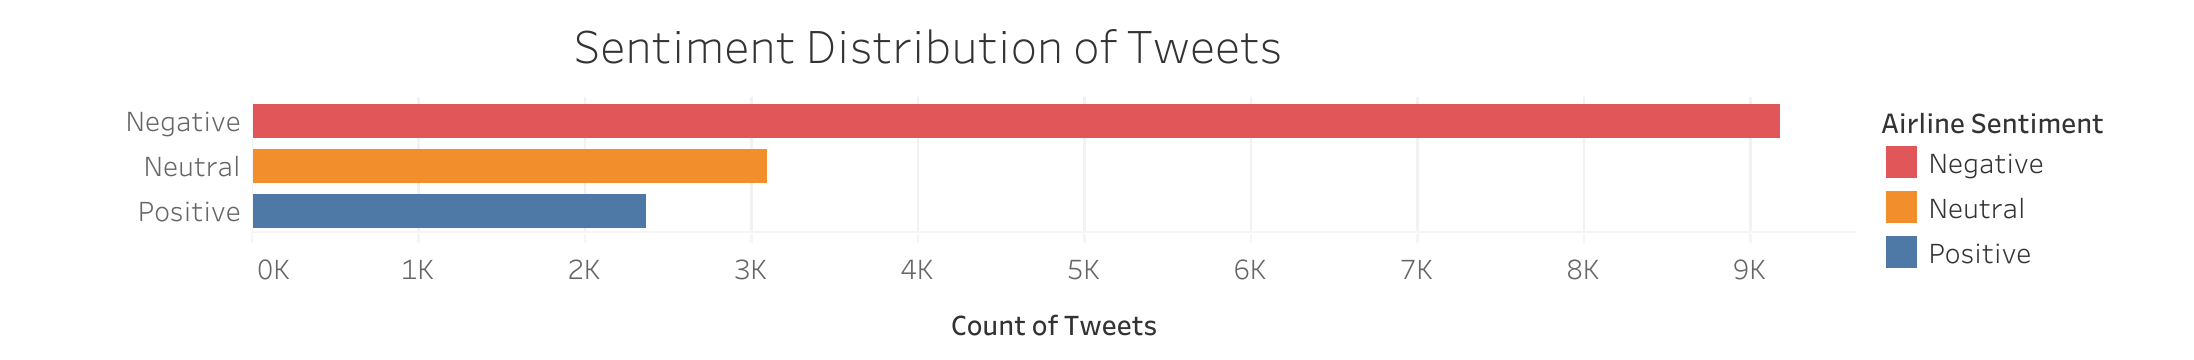

## Airline-Specific Analysis:
### Which airline received the most positive (and negative) sentiment in tweets?
Southwest Airlines received the most positive sentiment tweets, with 570 tweets, while United Airlines received the most negative sentiment tweets, reaching 2,633 tweets. Upon further investigation, it was discovered that in February 2015, United Airlines had a pricing glitch that offered discounted prices on their tickets. However, the airline cancelled thousands of tickets sold during the glitch, which could explain why there were so many negative tweets during that period.
US Airways received the second-highest number of negative tweets, with a total count of 2,263. This could have been due to an incident where a US Airways plane had to make an emergency landing as its landing gear failed to function properly. Although this event could explain a large portion of the negative tweets, it is worth noting that in later analysis, it was discovered that the most common reasons for negative tweets were not related to accidents or crashes.

In [15]:
# Read data from database using the query
sql_query = """
SELECT airline,
       SUM(CASE WHEN airline_sentiment = 'positive' THEN 1 ELSE 0 END) AS positive_count,
       SUM(CASE WHEN airline_sentiment = 'negative' THEN 1 ELSE 0 END) AS negative_count
FROM Tweets
GROUP BY airline
ORDER BY positive_count DESC, negative_count DESC;
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Print the query results
print("Total Tweets by Sentiment and Airline:")
raw_data = pd.read_sql_query(sql_query, engine)
print(raw_data.head())

# Find airline with most positive sentiment
airline_most_positive = df.loc[df['positive_count'].idxmax(), 'airline']
positive_count = df['positive_count'].max()

# Find airline with most negative sentiment
airline_most_negative = df.loc[df['negative_count'].idxmax(), 'airline']
negative_count = df['negative_count'].max()

# Print the results
print(f"Airline with Most Positive Sentiment: {airline_most_positive} ({positive_count} positive tweets)")
print(f"Airline with Most Negative Sentiment: {airline_most_negative} ({negative_count} negative tweets)")


Total Tweets by Sentiment and Airline:
      airline  positive_count  negative_count
0   Southwest             570            1186
1       Delta             544             955
2      United             492            2633
3    American             307            1864
4  US Airways             269            2263
Airline with Most Positive Sentiment: Southwest (570 positive tweets)
Airline with Most Negative Sentiment: United (2633 negative tweets)


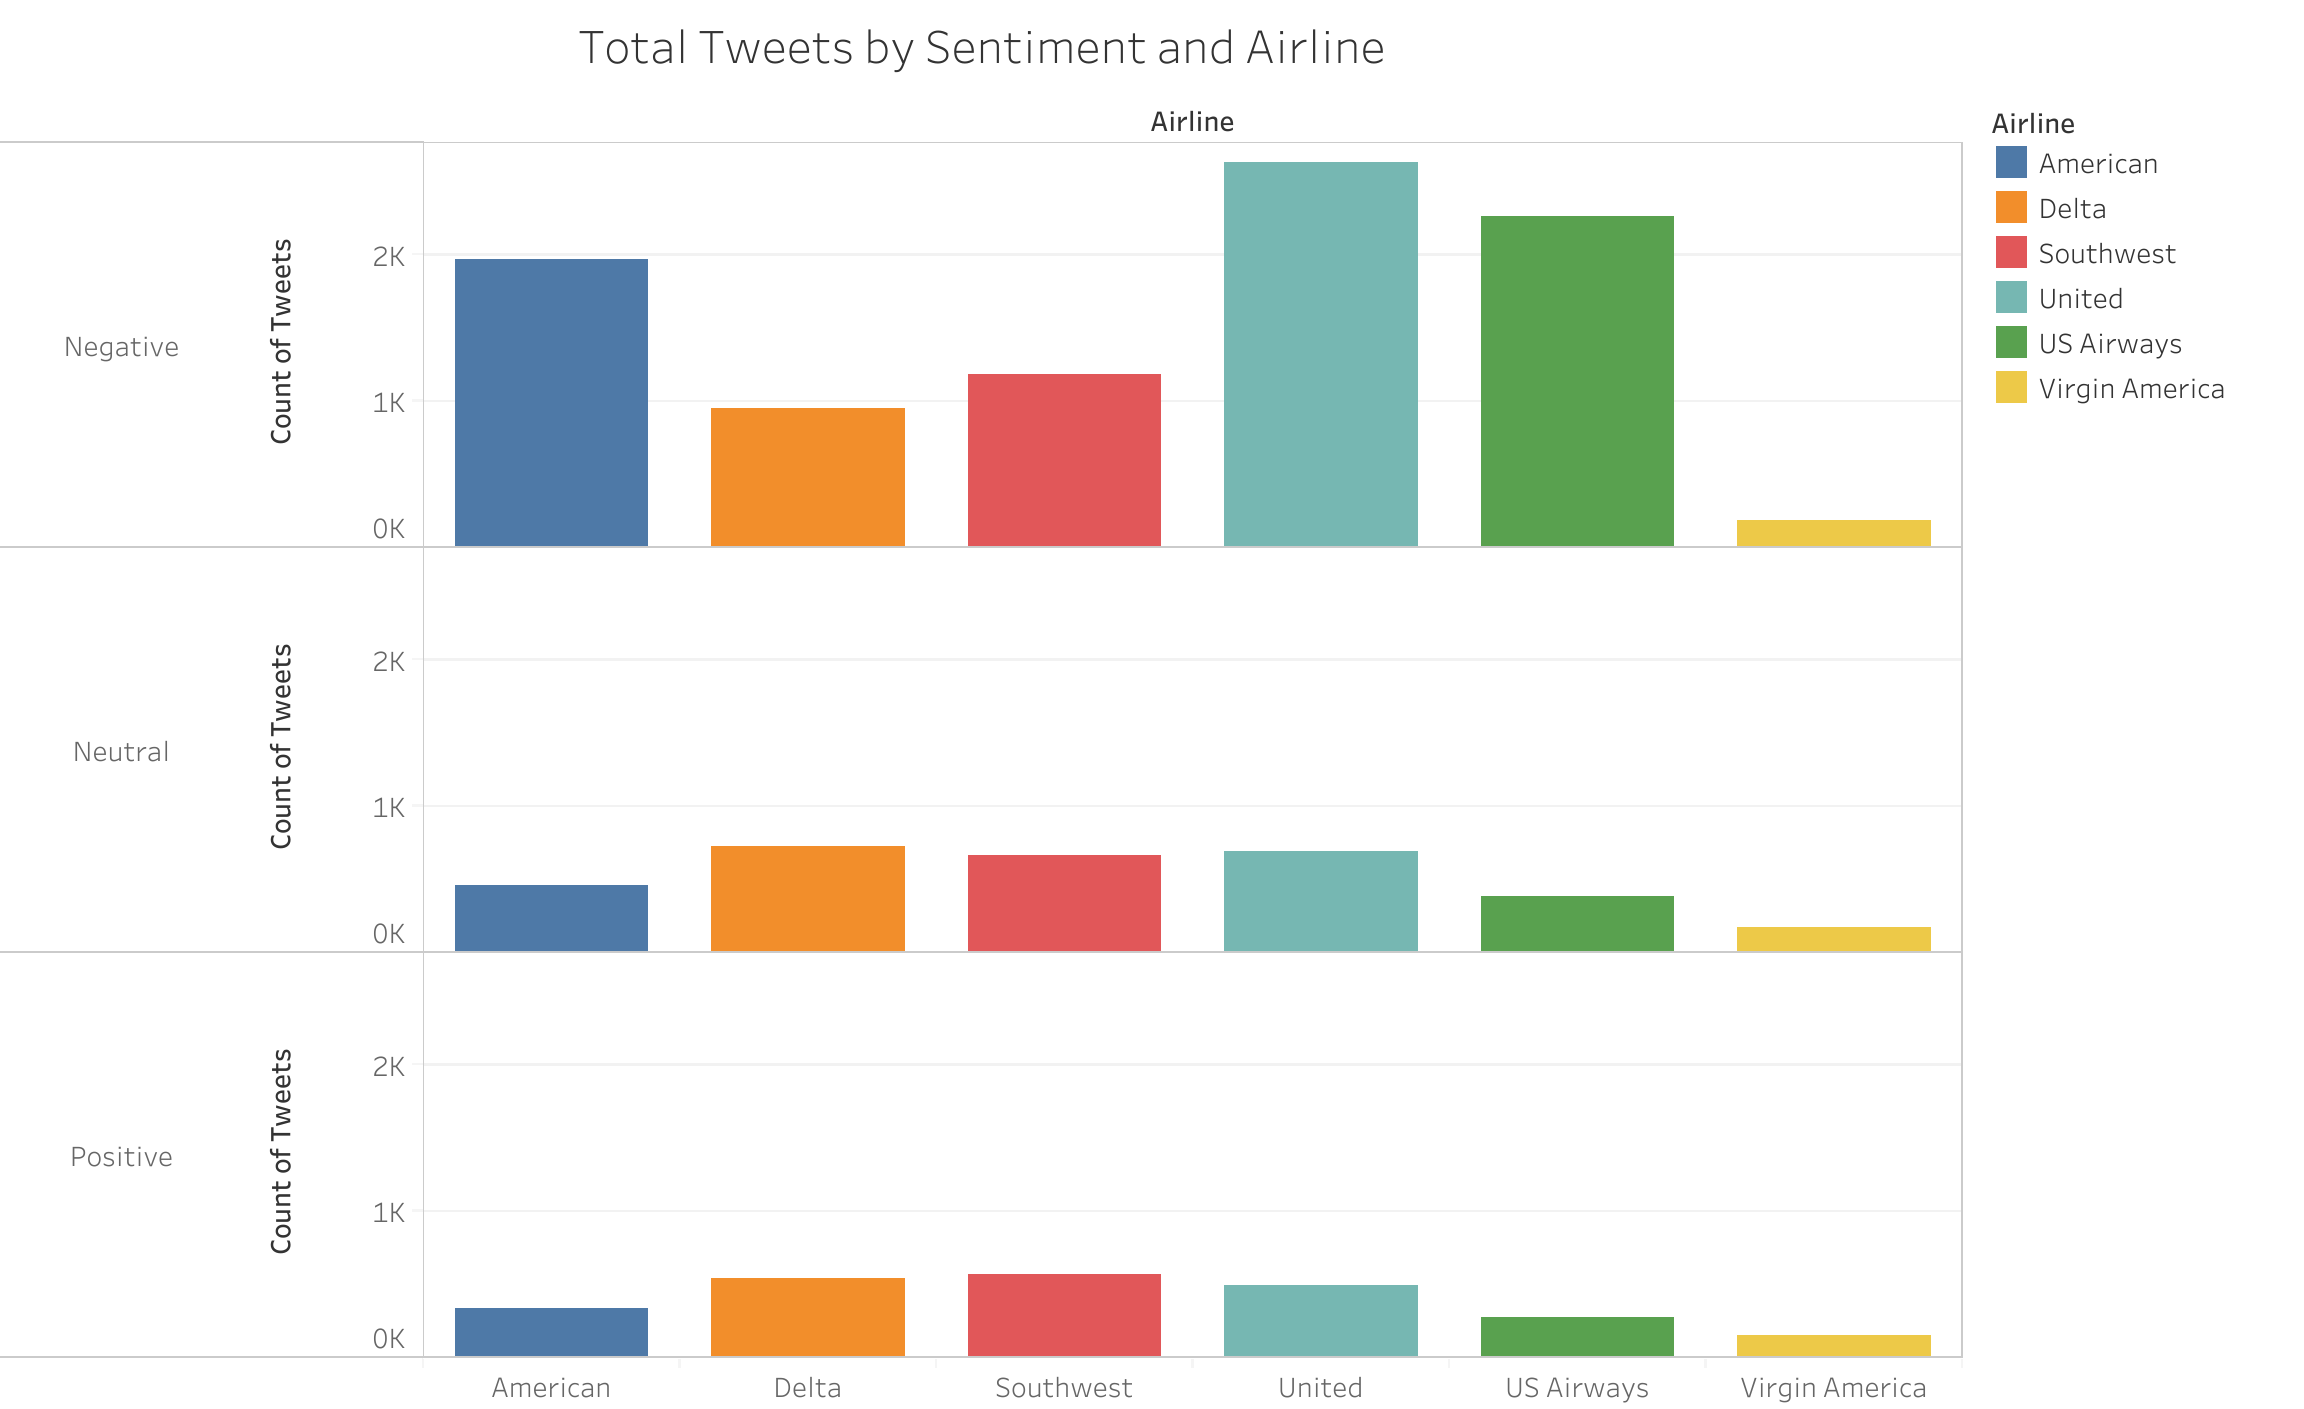

### Are there any significant differences in sentiment distribution among different airlines?
By analyzing the graph, it is evident that the two airline companies, United and US Airways, which have the highest number of negative tweets, have consistent numbers throughout the entire period. On the other hand, American Airlines experiences a significant surge in negative tweets after February 21st. A business analyst can use this information to identify the reasons for negative tweets and determine the most effective action to take.

In [16]:
# Read data from database using the query
sql_query = "SELECT * FROM Tweets"
df = pd.read_sql(sql_query, engine)

# Use 'tweet_created' column to find the date and create DataFrame
df['date'] = df['tweet_created'].apply(lambda x: datetime.datetime.strptime(x.split()[0], "%Y-%m-%d").date())

# Daily sentiment analysis
daily_sentiment = {}
for date, group_data in df.groupby('date'):
  airline_sentiment = group_data.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack(fill_value=0)
  daily_sentiment[date] = airline_sentiment

# Function to calculate and format daily sentiment table
def calculate_daily_sentiment(df):
  df['date'] = df['tweet_created'].apply(lambda x: datetime.datetime.strptime(x.split()[0], "%Y-%m-%d").date())
  daily_sentiment = df.groupby(['date', 'airline'])['airline_sentiment'].value_counts().unstack(fill_value=0)
  return daily_sentiment

# Calculate and print the daily sentiment table
daily_sentiment_table = calculate_daily_sentiment(df.copy())  # Use a copy to avoid modifying original data
print("Total Tweets by Sentiment and Airline per Day:")
print(daily_sentiment_table.to_string())

Total Tweets by Sentiment and Airline per Day:
airline_sentiment          negative  neutral  positive
date       airline                                    
2015-02-16 Delta                  1        1         0
           United                 2        0         0
2015-02-17 Delta                108       86        69
           Southwest            213       85        86
           US Airways           233       30        48
           United               272       75        49
           Virgin America        12       21        21
2015-02-18 American               1        0         0
           Delta                105       86        77
           Southwest            110      106        76
           US Airways           244       32        41
           United               257       90        59
           Virgin America        19       21        20
2015-02-19 American               0        0         1
           Delta                135       70        78
           Southwe

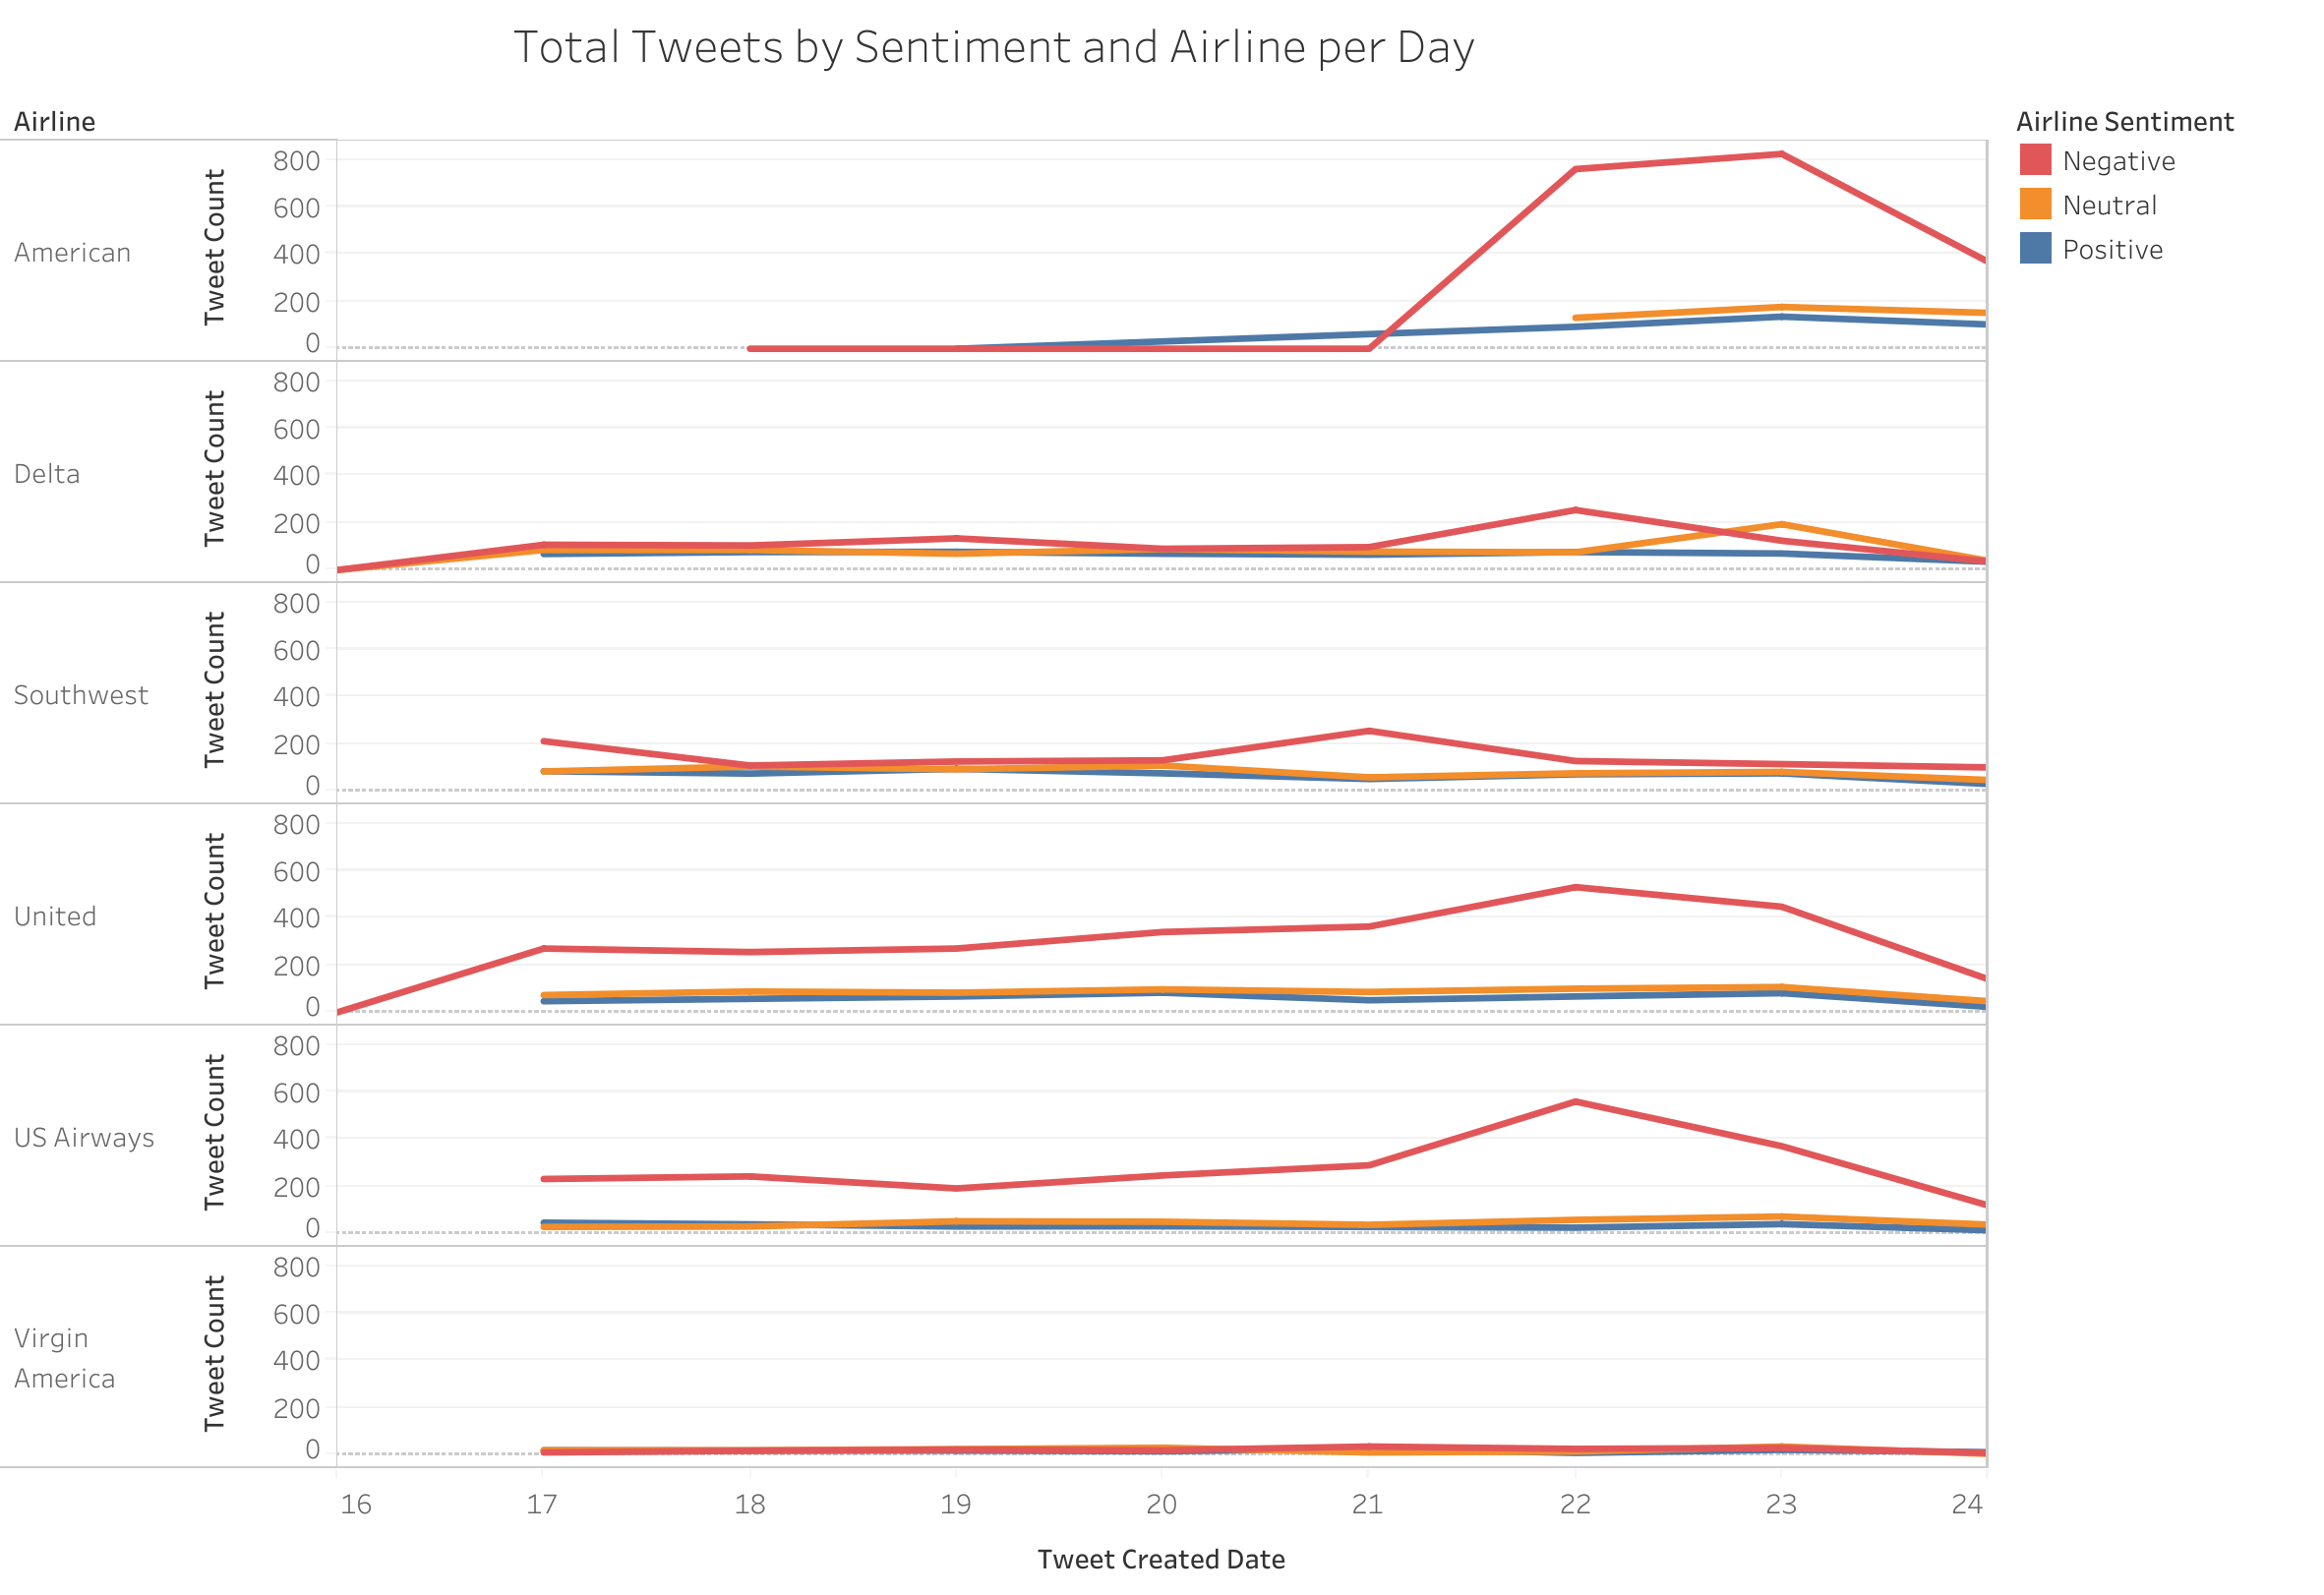

## Reason Analysis:
### What are the most common reasons mentioned in negative tweets (e.g., late flights, rude service, baggage issues)?
The main reasons for negative sentiment tweets on Twitter were customer service issues, followed by delayed or cancelled flights. Airlines can use this information to enhance their customer service practices and flight procedures, resulting in better reviews and increased revenue. It's worth noting that the reasons for negative sentiment were manually provided in the dataset. However, I conducted a different analysis to identify the reasons for positive sentiment, which were not included in the dataset. This (along with the analysis of negative sentiment tweets) can be found later in the analysis using tokens and n-grams. To obtain more information from tweets, businesses could benefit from implementing a machine learning AI tool that can identify both the sentiment and the provided reason.

In [17]:
# Read data from database using the query
sql_query = """
SELECT negativereason, COUNT(*) AS count
FROM Tweets
WHERE negativereason IS NOT "" AND negativereason <> "Can't Tell"
GROUP BY negativereason
ORDER BY count DESC
LIMIT 5;
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Print the results
print("Top 5 Most Frequent Reasons for Negative Tweets (and their counts):")
print(df)

Top 5 Most Frequent Reasons for Negative Tweets (and their counts):
           negativereason  count
0  Customer Service Issue   2885
1             Late Flight   1650
2        Cancelled Flight    829
3            Lost Luggage    719
4              Bad Flight    575


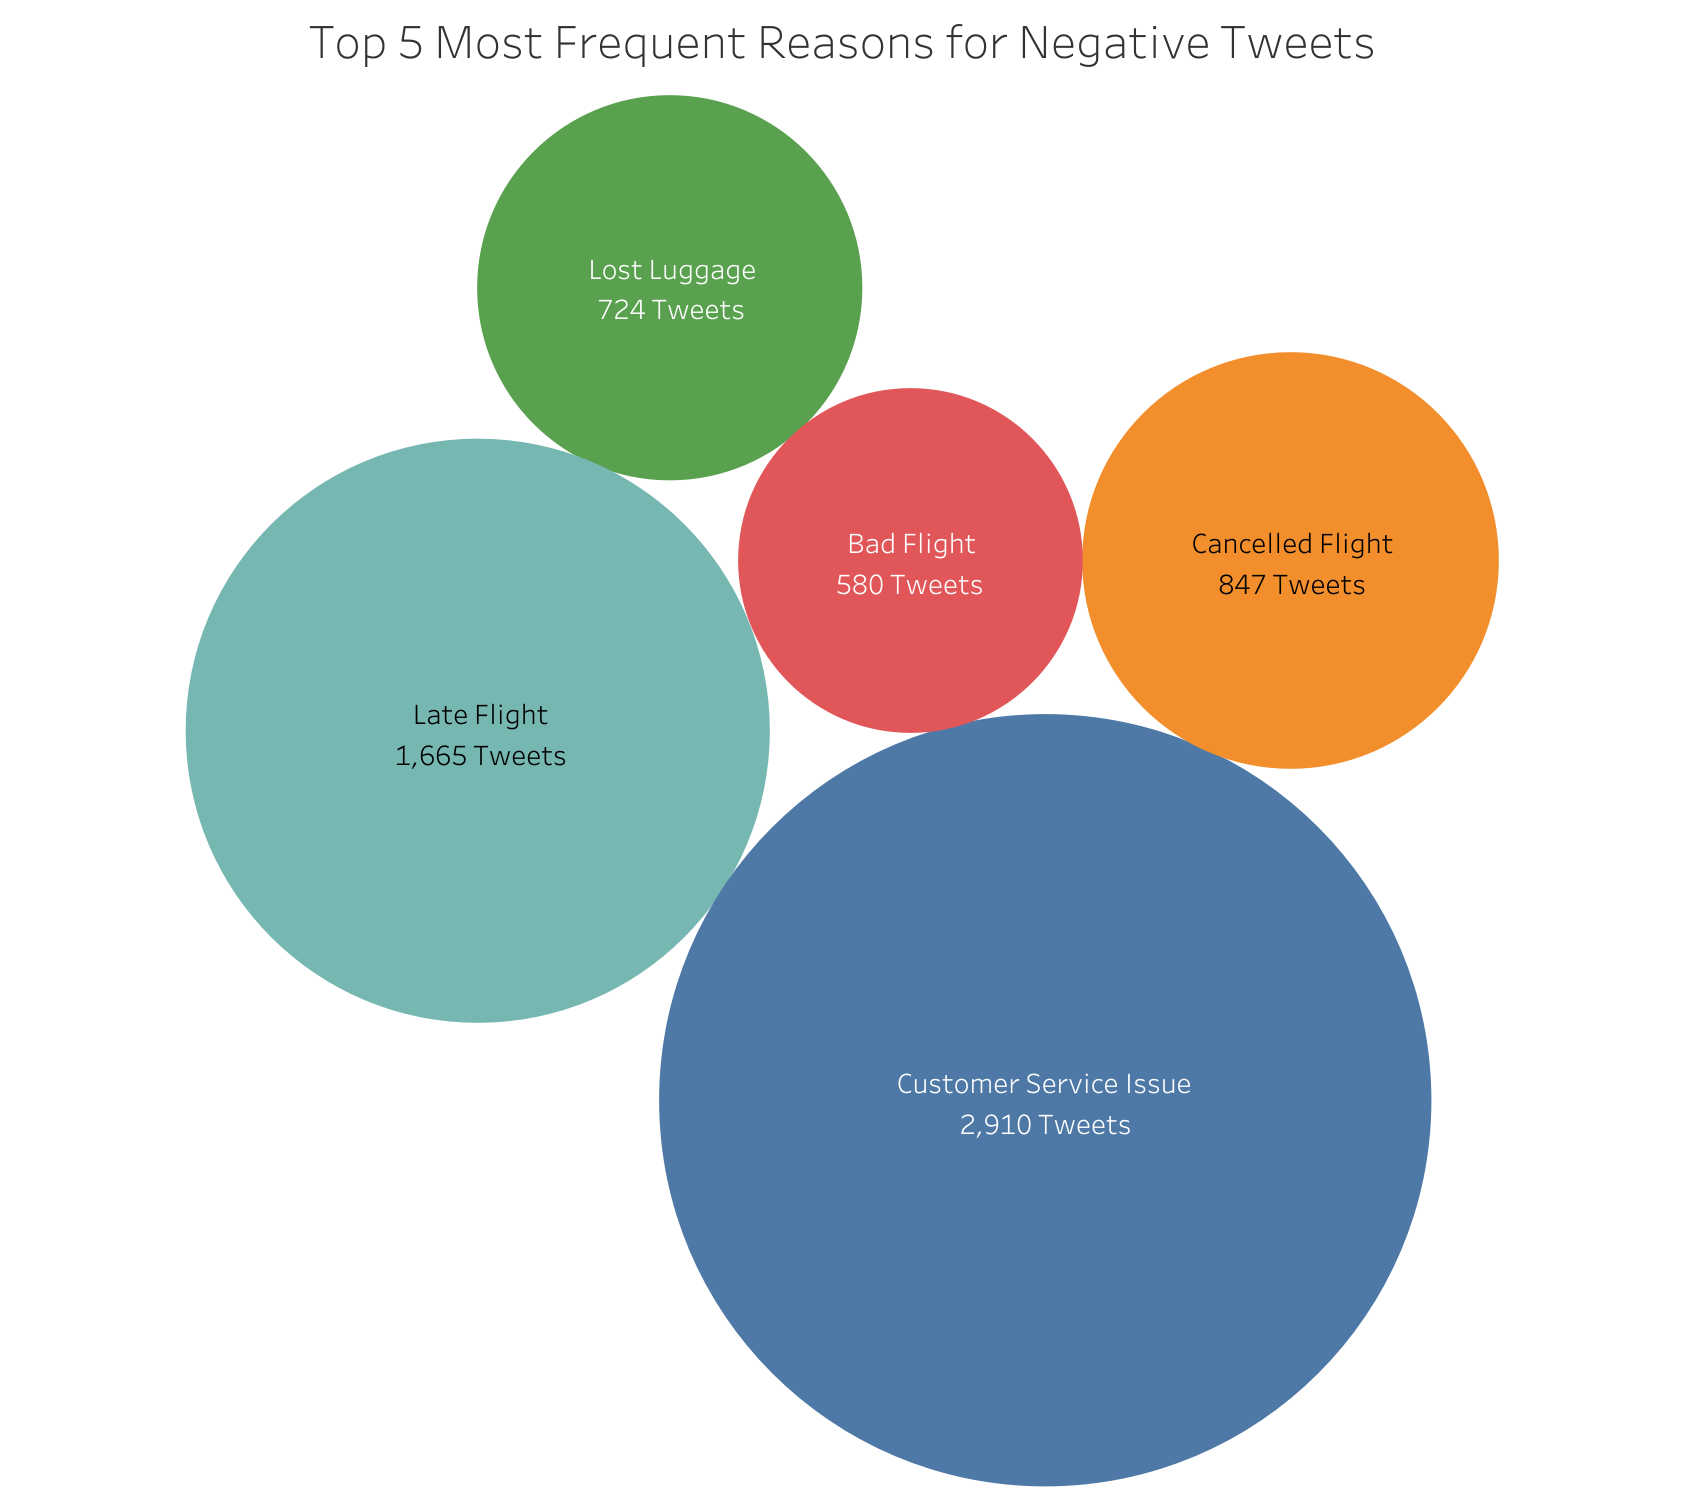

### Is there a correlation between the reason for negativity and the airline being tweeted about?
US Airways, American, and United were the companies contributing to the high numbers of negative tweets about customer service issues. United and US Airways had the most negative tweets about late flights. United was the only airline company in the top 10 co-occurances that mentioned lost luggage. With this information, United can specifically make changes to customer service, late flights, and lost luggage prevention.  

In [18]:
# Read data from database using the query
sql_query = """
SELECT negativereason, airline, COUNT(*) AS count
FROM Tweets
WHERE negativereason IS NOT "" AND negativereason <> "Can't Tell"
GROUP BY negativereason, airline
ORDER BY count DESC;
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Print the results 
print("Top 10 Co-occurrences of Reasons For Negative Tweets by Airline:")
print(df.head(10)) 

Top 10 Co-occurrences of Reasons For Negative Tweets by Airline:
           negativereason     airline  count
0  Customer Service Issue  US Airways    811
1  Customer Service Issue    American    743
2  Customer Service Issue      United    681
3             Late Flight      United    525
4             Late Flight  US Airways    453
5  Customer Service Issue   Southwest    391
6             Late Flight       Delta    269
7            Lost Luggage      United    269
8             Late Flight    American    234
9        Cancelled Flight    American    228


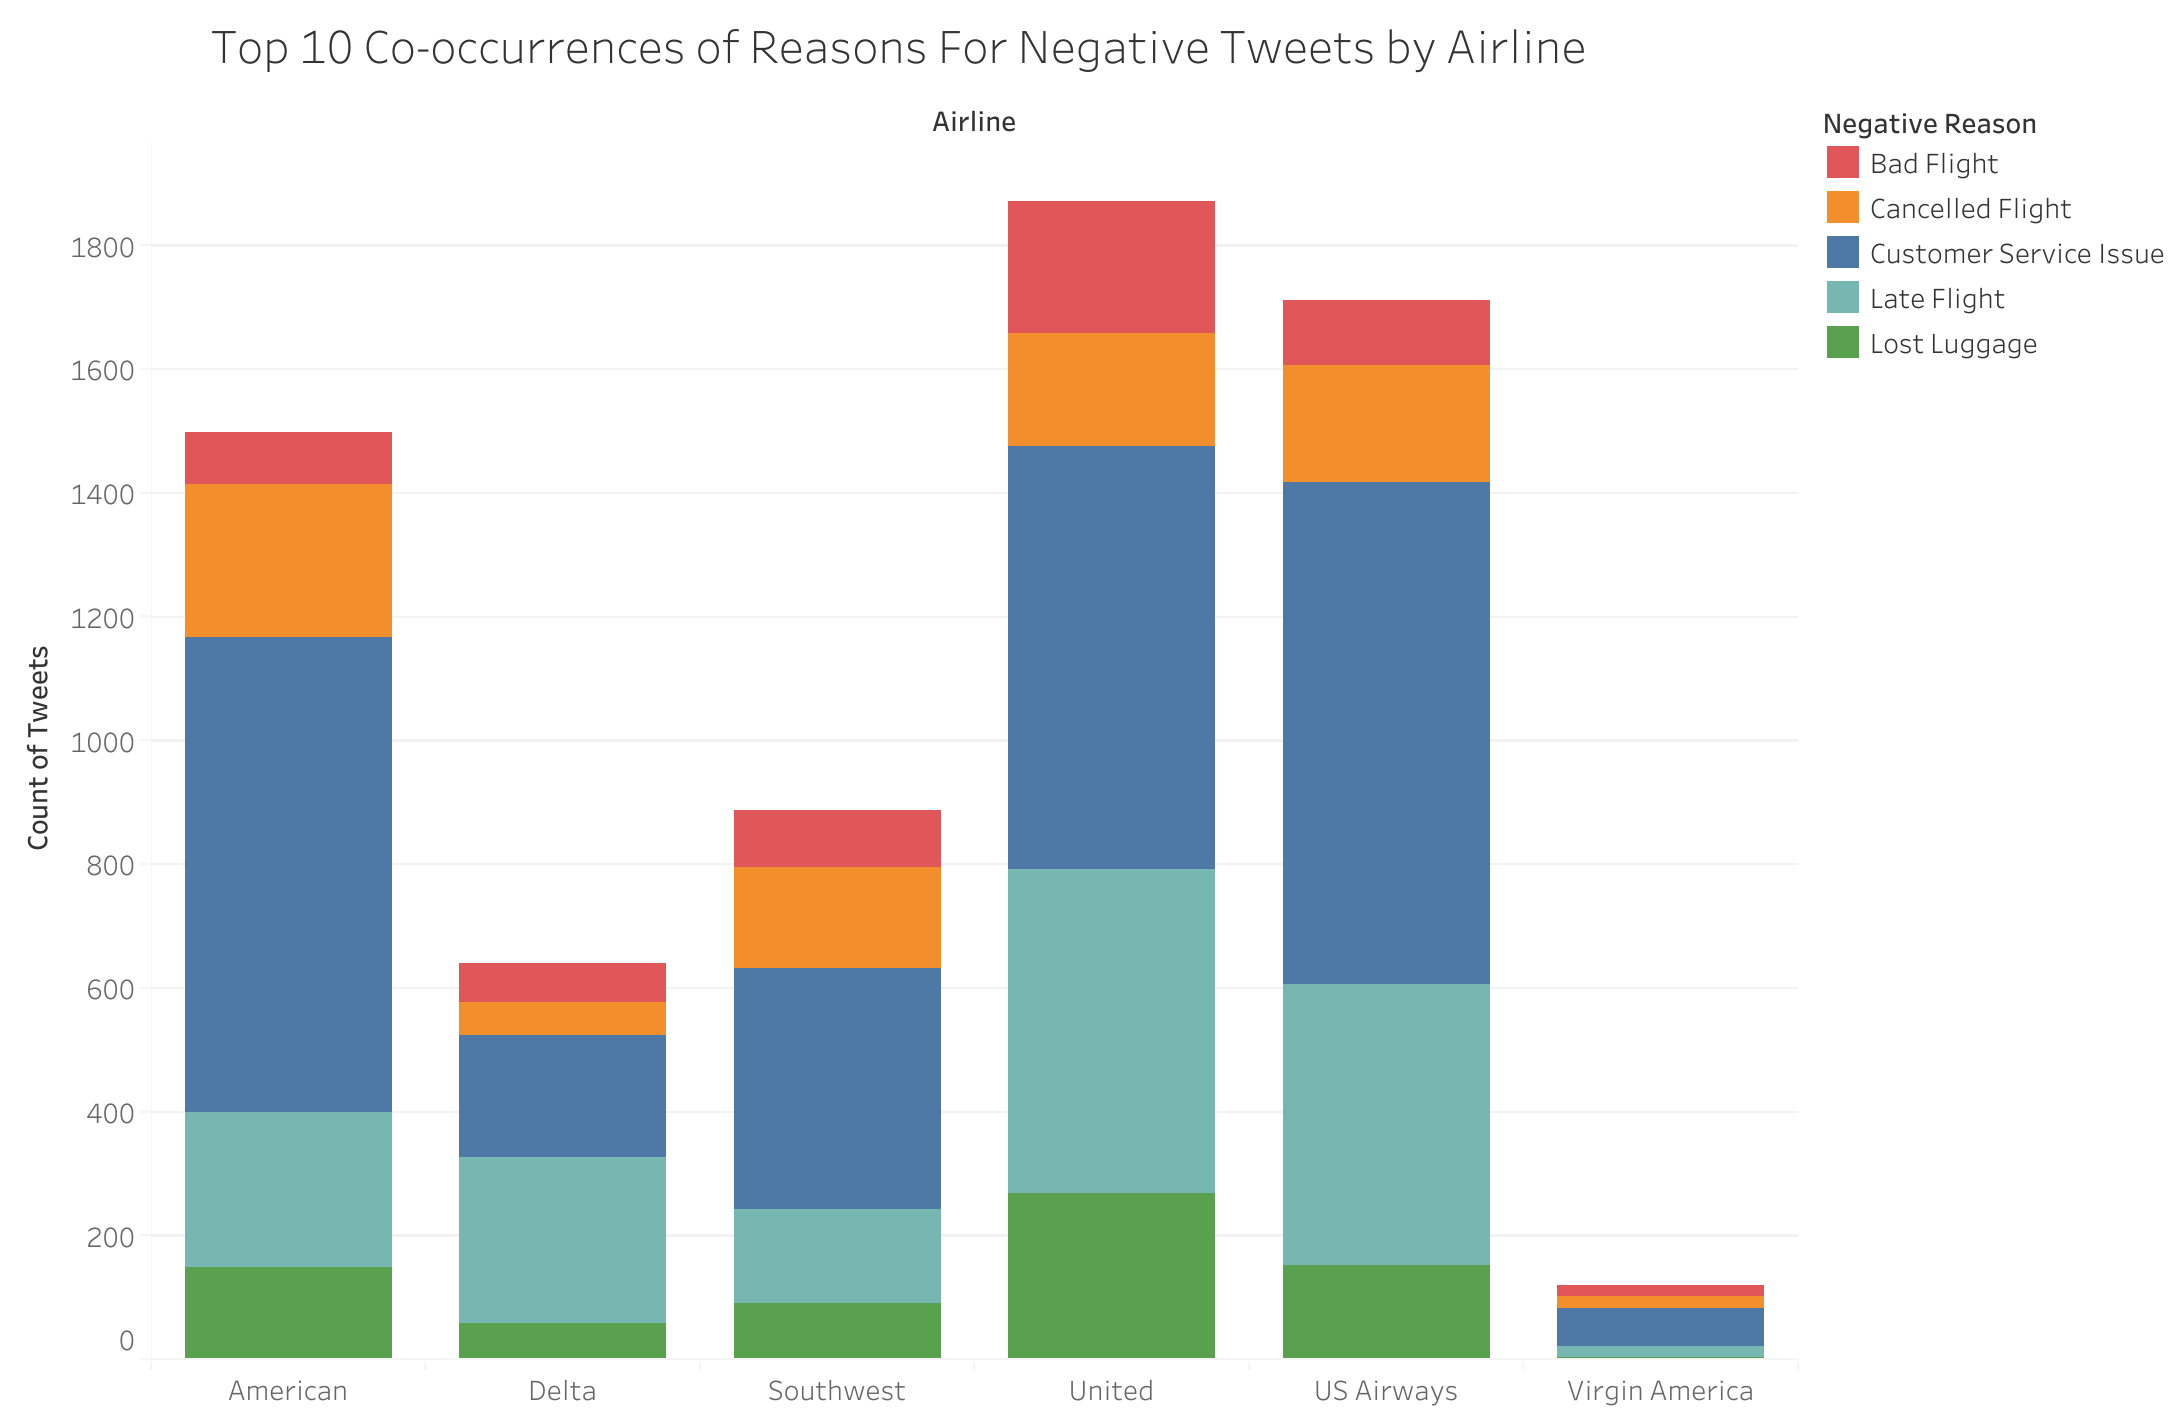

### What are the most common reasons mentioned in positive tweets?
The most common reason found in positive tweets were customer service, followed by great flight/job, then flight attendants. Using this information, an airline company can do multiple things, such as emphasize good customer service when marketing or set their attention to other parts of the company which still need improvement.

As I mentioned earlier, we are gathering two-word phrases from plain text tweets using tokens and n-grams. To achieve this, we need to remove stop words and punctuation so that we can obtain the best results. However, some words had to be removed because of suffixes and hyperlink sections that didn't make sense. As a result, their values were not counted in the ones that were spelled correctly. For instance, tweets like "cancelled flightled" were not added to the total "cancelled flight" tweets. This caused a little bit of data loss, but the top positive reasons remained at the top, even after removing the data.

In [19]:
# Define stop words
stop_words = set(stopwords.words('english'))
airline_names = {"southwestair","united", "usairways", "americanair", "delta", "southwest", "jetblue"}
common_fault_words = {"flightled", "flightr", "flighted", "http", "fleek", "fleet", "get", "problem", "thanks", "thank", "ca"}
words_to_exclude = stop_words.union(airline_names, common_fault_words)

# Read data from database using the query
sql_query = """
SELECT t.text
FROM Tweets t
WHERE t.airline_sentiment = 'positive'
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Process text data (outside the SQL query)
def process_text(text):
  tokens = nltk.word_tokenize(text.lower())  # Lowercase for case-insensitivity
  tokens = [word for word in tokens if word.isalpha()]  # Keep only letters
  filtered_tokens = [token for token in tokens if token not in words_to_exclude]
  return filtered_tokens

# Apply processing to each text
df['processed_text'] = df['text'].apply(process_text)

# Combine all processed text into a single list
all_words = []
for tokens in df['processed_text']:
  all_words.extend(tokens)

# Create a Counter object to count word frequencies
word_counts = Counter(all_words)

# Generate n-grams from processed text
n = 2
all_ngrams = []
for tokens in df['processed_text']:
  all_ngrams.extend(zip(*[tokens[i:] for i in range(n)]))

ngram_counts = Counter(all_ngrams)

# Display most frequent n-grams (excluding stop words)
print("Top", n, "Word Phrases (excluding stop words) associated with Positive Flights:")
for ngram, count in ngram_counts.most_common(10): 
  print(f"{' '.join(ngram)}: {count}")

Top 2 Word Phrases (excluding stop words) associated with Positive Flights:
customer service: 91
great flight: 27
great job: 22
flight attendant: 20
looking forward: 18
great service: 17
quick response: 16
best airline: 15
good work: 14
great customer: 14


## User Analysis:
### Are there any frequent flyers (users with a high number of tweets) who consistently express positive or negative sentiment?
There were many Twitter accounts that tweeted more than 10 times between February 16th to February 24th. However, only the top 20 were displayed. It was surprising to see that there were no official company accounts among the top ones. Most of the users had an overall negative sentiment, except for a few who had an overall neutral sentiment.

In [20]:
frequent_flyer_threshold = 10

# Read data from database using the query
sql_query = f"""
SELECT name, airline_sentiment, COUNT(*) AS tweet_count
FROM Tweets
GROUP BY name
HAVING tweet_count >= {frequent_flyer_threshold}  
ORDER BY tweet_count DESC
LIMIT 20;
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

print("Top 20 Frequent Flyers with Dominant Sentiment (Most Tweets to Least):")
print(df)

Top 20 Frequent Flyers with Dominant Sentiment (Most Tweets to Least):
               name airline_sentiment  tweet_count
0       JetBlueNews           neutral           63
1       kbosspotter           neutral           32
2           _mhertz          negative           29
3           otisday          negative           28
4          throthra          negative           27
5          rossj987          negative           23
6   weezerandburnie          negative           22
7      GREATNESSEOA          negative           22
8     scoobydoo9749          negative           21
9       jasemccarty          negative           20
10     MeeestarCoke          negative           20
11    georgetietjen           neutral           19
12     ElmiraBudMan          negative           19
13   thomashoward88          negative           18
14     flemmingerin          negative           18
15   ThatJasonEaton          negative           18
16         Aero0729          negative           18
17     worl

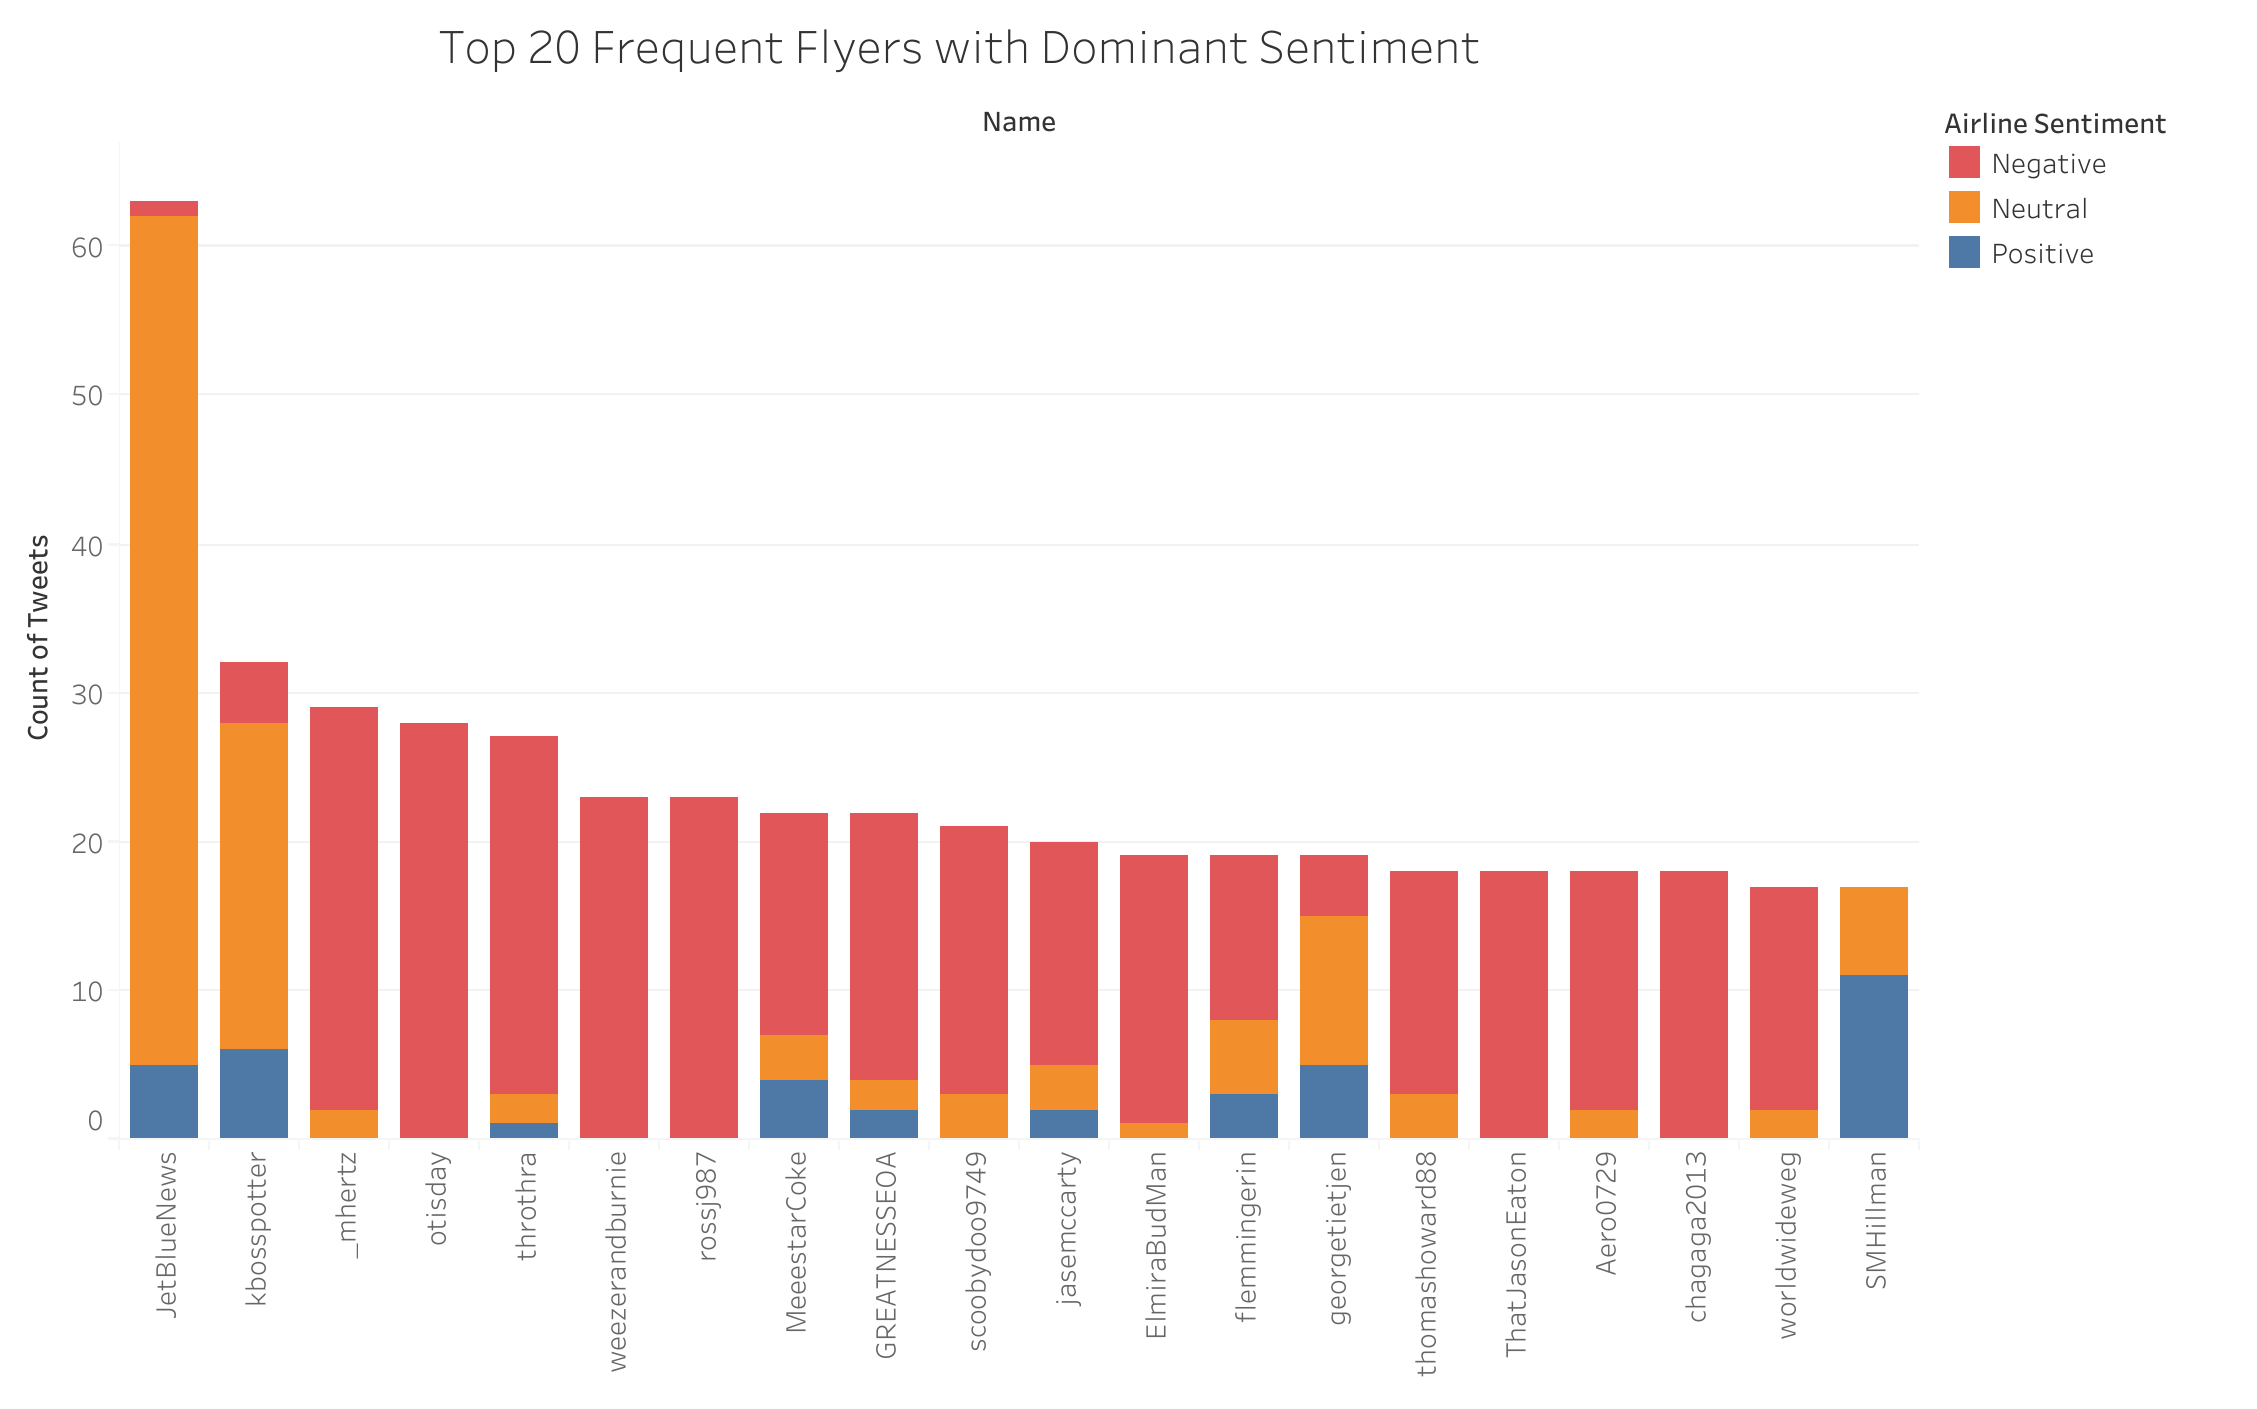

## Additional Exploration:
### What are the most common reasons mentioned in negative tweets? - Using tokens and n-grams
I wanted to see if I could extract more information from tweet text besides what's provided in the "negativereason" column. To do this, I used the same method as for positive sentiment. However, I had to remove many words due to random letters at the end (especially "flight"). This caused some data loss, but the top negative reasons remained in order even after removing this data. Although the method is not perfect, it helped me to gain additional insights from the tweet text.

In [21]:
# Define stop words
stop_words = set(stopwords.words('english'))
airline_names = {"southwestair","united", "usairways", "americanair", "delta", "southwest", "jetblue"}
common_fault_words = {"flightled", "flightr", "flighted", "http", "fleek", "fleet", "get"}
words_to_exclude = stop_words.union(airline_names, common_fault_words)

# Read data from database using the query
sql_query = """
SELECT t.text
FROM Tweets t
WHERE t.airline_sentiment = 'negative'
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Process text data (outside the SQL query)
def process_text(text):
  tokens = nltk.word_tokenize(text.lower())  # Lowercase for case-insensitivity
  tokens = [word for word in tokens if word.isalpha()]  # Keep only letters
  filtered_tokens = [token for token in tokens if token not in words_to_exclude]
  return filtered_tokens

# Apply processing to each text
df['processed_text'] = df['text'].apply(process_text)

# Combine all processed text into a single list
all_words = []
for tokens in df['processed_text']:
  all_words.extend(tokens)

# Create a Counter object to count word frequencies
word_counts = Counter(all_words)

# Generate n-grams from processed text
n = 2
all_ngrams = []
for tokens in df['processed_text']:
  all_ngrams.extend(zip(*[tokens[i:] for i in range(n)]))

ngram_counts = Counter(all_ngrams)

# Display most frequent n-grams (excluding stop words)
print("Top", n, "-Word Phrases (excluding stop words) associated with Negative Flights:")
for ngram, count in ngram_counts.most_common(10): 
  print(f"{' '.join(ngram)}: {count}")


Top 2 -Word Phrases (excluding stop words) associated with Negative Flights:
customer service: 441
cancelled flight: 256
late flight: 225
flight cancelled: 204
flight delayed: 120
call back: 99
booking problems: 97
hold hours: 67
gate agent: 60
please help: 59


### Is there a correlation between airline sentiment and location?
Below is a query that aims to identify if there are similar sentiments in the same locations. However, the data analyzed is incomplete, as it is provided by the dataset and seems to be taken from the bios of Twitter users. This leads to inconsistent names of locations in various languages. To enhance the accuracy of this query, it would be beneficial to create a new location column that utilizes a uniform location template.

In [22]:
# Read data from database using the query
sql_query = """
SELECT tweet_location, airline_sentiment, COUNT(*) AS tweet_count
FROM Tweets
WHERE tweet_location IS NOT ""
GROUP BY tweet_location, airline_sentiment
ORDER BY tweet_location, airline_sentiment;
"""

# Use pandas to create DataFrame
df = pd.read_sql(sql_query, engine)

# Print results (showing sentiment distribution per location)
print("Sentiment Distribution by Location:")
print(df.groupby('tweet_location')['airline_sentiment'].value_counts())


Sentiment Distribution by Location:
tweet_location             airline_sentiment
  || san antonio, texas||  neutral              1
 Bronx, NY / Destin, Fl    neutral              1
 California 92705          neutral              1
 D(MD)V ✈️ NYC ✈️ Germany  neutral              1
 DC | Jersey City          negative             1
                                               ..
✡ Los Angeles ✡            neutral              1
✨                          negative             1
❤                          negative             1
サマセット、ニュージャージー州            neutral              1
명동서식 37.56638,126.984994   negative             1
Name: count, Length: 4139, dtype: int64


By exploring these questions, I was able to gain valuable insights into how travelers felt about US airlines in February 2015. The findings may be useful for airlines to improve their customer service and identify areas for improvement.
